In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yiweilu2033/well-documented-alzheimers-dataset")

print("Path to dataset files:", path)

100%|██████████| 4.02G/4.02G [03:08<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yiweilu2033/well-documented-alzheimers-dataset/versions/2


In [ ]:
import os

def count_images_in_folders(dataset_path):
    folder_counts = {}

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            # Buscar subcarpeta con el mismo nombre (excepto para 'NonDemented')
            subfolder_name = folder if "NonDemented" not in folder else "NonDemented"
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                image_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
                folder_counts[folder] = image_count
            else:
               print(f"Subcarpeta no encontrada en: {folder_path}")

    return folder_counts

# Ruta del dataset

image_counts = count_images_in_folders(path)

# Imprimir resultados
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")


ModerateDemented: 376 imágenes
MildDemented: 5184 imágenes
VeryMildDemented: 13796 imágenes
NonDemented (2): 63560 imágenes


In [ ]:
import os

def count_images_in_folders(dataset_path):
    folder_counts = {}

    for folder in os.listdir(dataset_path):
        # Omitir la carpeta "ModerateDemented"
        if folder == "ModerateDemented":
            continue

        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            # Buscar subcarpeta con el mismo nombre (excepto para 'NonDemented')
            subfolder_name = folder if "NonDemented" not in folder else "NonDemented"
            subfolder_path = os.path.join(folder_path, subfolder_name)

            if os.path.isdir(subfolder_path):
                image_count = len([f for f in os.listdir(subfolder_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))])
                folder_counts[folder] = image_count
            else:
                print(f"Subcarpeta no encontrada en: {folder_path}")

    return folder_counts

# Ruta del dataset

image_counts = count_images_in_folders(path)

# Imprimir resultados
for folder, count in image_counts.items():
    print(f"{folder}: {count} imágenes")


MildDemented: 5184 imágenes
VeryMildDemented: 13796 imágenes
NonDemented (2): 63560 imágenes


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Base del dataset descargado
base_dir = path

# Estructura del dataset: categorías válidas (sin ModerateDemented)
category_subfolders = {
    "MildDemented": "MildDemented",
    "VeryMildDemented": "VeryMildDemented",
    "NonDemented (2)": "NonDemented"
}

# Diccionarios para almacenar info
patient_images = {}  # patient_id -> list of image paths
patient_labels = {}  # patient_id -> label

# Recorremos cada clase
for category, subfolder in category_subfolders.items():
    category_path = os.path.join(base_dir, category, subfolder)

    if not os.path.exists(category_path):
        print(f"Advertencia: Carpeta no encontrada {category_path}")
        continue

    for img_name in os.listdir(category_path):
        if not img_name.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        # Extraer patient ID y slice
        parts = img_name.split("_")
        patient_id = "_".join(parts[:3])  # ejemplo: OAS1_0028_MR1
        slice_number = int(parts[-1].replace(".png", "").replace(".jpg", "").replace(".jpeg", "").replace("slice_", ""))

        img_path = os.path.join(category_path, img_name)

        if patient_id not in patient_images:
            patient_images[patient_id] = []

        patient_images[patient_id].append((slice_number, img_path))
        patient_labels[patient_id] = category  # Asumimos que todas las imágenes del paciente están en la misma carpeta

# Seleccionar solo la imagen central por paciente
image_paths = []
patient_ids = []
labels = []

for patient_id, slices in patient_images.items():
    # Ordenar por número de slice
    sorted_slices = sorted(slices, key=lambda x: x[0])
    central_index = len(sorted_slices) // 2
    central_slice_path = sorted_slices[central_index][1]

    image_paths.append(central_slice_path)
    patient_ids.append(patient_id)
    labels.append(patient_labels[patient_id])

# Crear DataFrame
images_df = pd.DataFrame({
    "image_path": image_paths,
    "patient_id": patient_ids,
    "label": labels
})

# Estratificación por paciente
unique_patient_ids = images_df["patient_id"].unique()
patient_labels_series = images_df.groupby("patient_id")["label"].first()

# Split en pacientes (80% train, 10% val, 10% test)
train_ids, test_ids = train_test_split(
    unique_patient_ids, test_size=0.2, random_state=42,
    stratify=patient_labels_series.loc[unique_patient_ids]
)
train_ids, val_ids = train_test_split(
    train_ids, test_size=0.2, random_state=42,
    stratify=patient_labels_series.loc[train_ids]
)

# Asignar set a cada imagen
set_assignment = []
for pid in patient_ids:
    if pid in train_ids:
        set_assignment.append("train")
    elif pid in val_ids:
        set_assignment.append("val")
    else:
        set_assignment.append("test")

# DataFrame final
final_df = pd.DataFrame({
    "image_path": image_paths,
    "patient_id": patient_ids,
    "label": labels,
    "set": set_assignment
})

# Mostrar tamaño por conjunto
print(f"Tamaño entrenamiento: {sum(final_df['set'] == 'train')}")
print(f"Tamaño validación: {sum(final_df['set'] == 'val')}")
print(f"Tamaño test: {sum(final_df['set'] == 'test')}")
print(final_df.head())


Tamaño entrenamiento: 277
Tamaño validación: 70
Tamaño test: 87
                                          image_path     patient_id  \
0  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0184_MR1   
1  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0052_MR1   
2  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0031_MR1   
3  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0067_MR1   
4  /root/.cache/kagglehub/datasets/yiweilu2033/we...  OAS1_0137_MR1   

          label    set  
0  MildDemented  train  
1  MildDemented  train  
2  MildDemented  train  
3  MildDemented  train  
4  MildDemented  train  


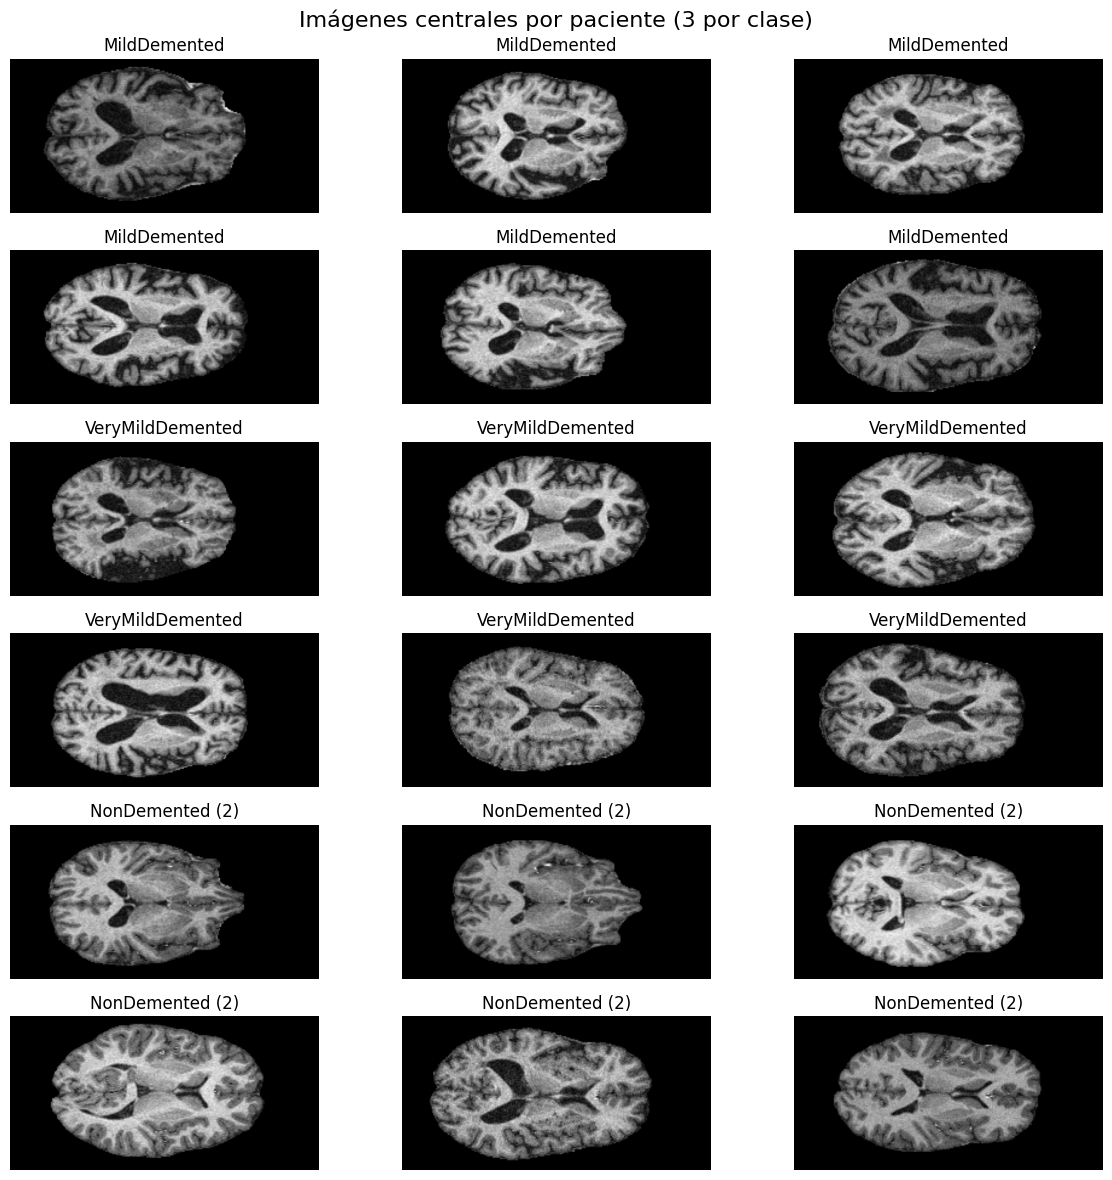

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Etiquetas que queremos visualizar
categories = ["MildDemented", "VeryMildDemented", "NonDemented (2)"]

# Seleccionar 3 imágenes por categoría
samples = []
for category in categories:
    category_df = final_df[final_df["label"] == category]
    sampled = category_df.sample(n=6, random_state=42)
    samples.append(sampled)

# Combinar las muestras en un solo DataFrame
sample_df = pd.concat(samples).reset_index(drop=True)

# Mostrar las imágenes
fig, axes = plt.subplots(6, 3, figsize=(12, 12))
fig.suptitle("Imágenes centrales por paciente (3 por clase)", fontsize=16)

for i, ax in enumerate(axes.flat):
    img_path = sample_df.loc[i, "image_path"]
    label = sample_df.loc[i, "label"]

    try:
        image = Image.open(img_path)
        ax.imshow(image, cmap='gray')  # Elimina cmap='gray' si son RGB
        ax.set_title(label)
        ax.axis('off')
    except Exception as e:
        print(f"Error al cargar {img_path}: {e}")
        ax.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Mapeo de etiquetas a números
label_map = {
    "MildDemented": 0,
    "VeryMildDemented": 1,
    "NonDemented (2)": 2
}

# Dataset personalizado
class AlzheimerCentralSliceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        label = label_map[self.df.iloc[idx]["label"]]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
# Dividir el DataFrame final en train/val/test
train_df = final_df[final_df["set"] == "train"]
val_df = final_df[final_df["set"] == "val"]
test_df = final_df[final_df["set"] == "test"]

# Crear datasets
train_dataset = AlzheimerCentralSliceDataset(train_df, transform=transform)
val_dataset = AlzheimerCentralSliceDataset(val_df, transform=transform)
test_dataset = AlzheimerCentralSliceDataset(test_df, transform=transform)

# Crear dataloaders
batch_size = 128  # Puedes ajustar esto
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verificación
print(f"Tamaño del dataset -> Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"DataLoaders listos con batch_size={batch_size}")


Tamaño del dataset -> Train: 277, Val: 70, Test: 87
DataLoaders listos con batch_size=128


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class AlzheimerResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlzheimerResNet, self).__init__()

        # Cargar modelo ResNet18 preentrenado
        self.resnet = models.resnet18(pretrained=False)

        # Congelar capas si no querés que se actualicen durante el entrenamiento
        # for param in self.resnet.parameters():
        #     param.requires_grad = False

        # Reemplazar la capa fully connected final por una nueva con 3 salidas
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Inicializar el modelo con 3 clases
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlzheimerResNet(num_classes=3).to(device)

print(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlzheimerResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from google.colab import files

# 1. Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 2. Función para entrenar usando F1-score como criterio
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    train_losses = []
    train_accuracies = []  # Lista para guardar la precisión de entrenamiento
    val_losses = []  # Lista para guardar la pérdida de validación
    val_f1_scores = []
    val_accuracies = []
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        # Entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels)
            total_preds += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_preds / total_preds
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())  # Guardamos el accuracy de entrenamiento

        # VALIDACIÓN
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)  # Guardamos la pérdida de validación

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        epoch_val_loss = running_val_loss / len(val_loader.dataset)  # Promedio de la pérdida de validación
        val_losses.append(epoch_val_loss)
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1_scores.append(val_f1)
        val_accuracies.append(val_acc)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Mejor modelo guardado en la época {epoch+1} con F1: {val_f1:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f} - "
              f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, F1 Score: {val_f1:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores

# 3. Evaluar usando F1-score
def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')  # o 'weighted'

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    return acc, f1

# 4. Entrenamiento
num_epochs = 25
train_losses, train_accuracies, val_losses, val_accuracies, val_f1_scores = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# 5. Evaluación
test_accuracy, test_f1 = evaluate_model(model, test_loader)


Mejor modelo guardado en la época 1 con F1: 0.0802
Epoch 1/25 - Train Loss: 1.1314, Train Accuracy: 0.4188 - Validation Loss: 1.3062, Validation Accuracy: 0.0714, F1 Score: 0.0802
Mejor modelo guardado en la época 2 con F1: 0.2842
Epoch 2/25 - Train Loss: 0.6732, Train Accuracy: 0.7870 - Validation Loss: 14.8081, Validation Accuracy: 0.7429, F1 Score: 0.2842
Mejor modelo guardado en la época 3 con F1: 0.2903
Epoch 3/25 - Train Loss: 0.8237, Train Accuracy: 0.6643 - Validation Loss: 28.9546, Validation Accuracy: 0.7714, F1 Score: 0.2903
Epoch 4/25 - Train Loss: 0.5066, Train Accuracy: 0.7617 - Validation Loss: 26.5358, Validation Accuracy: 0.7714, F1 Score: 0.2903
Epoch 5/25 - Train Loss: 0.4516, Train Accuracy: 0.7617 - Validation Loss: 21.3117, Validation Accuracy: 0.7714, F1 Score: 0.2903
Epoch 6/25 - Train Loss: 0.4135, Train Accuracy: 0.8014 - Validation Loss: 18.5533, Validation Accuracy: 0.7714, F1 Score: 0.2903
Epoch 7/25 - Train Loss: 0.4241, Train Accuracy: 0.8195 - Validation

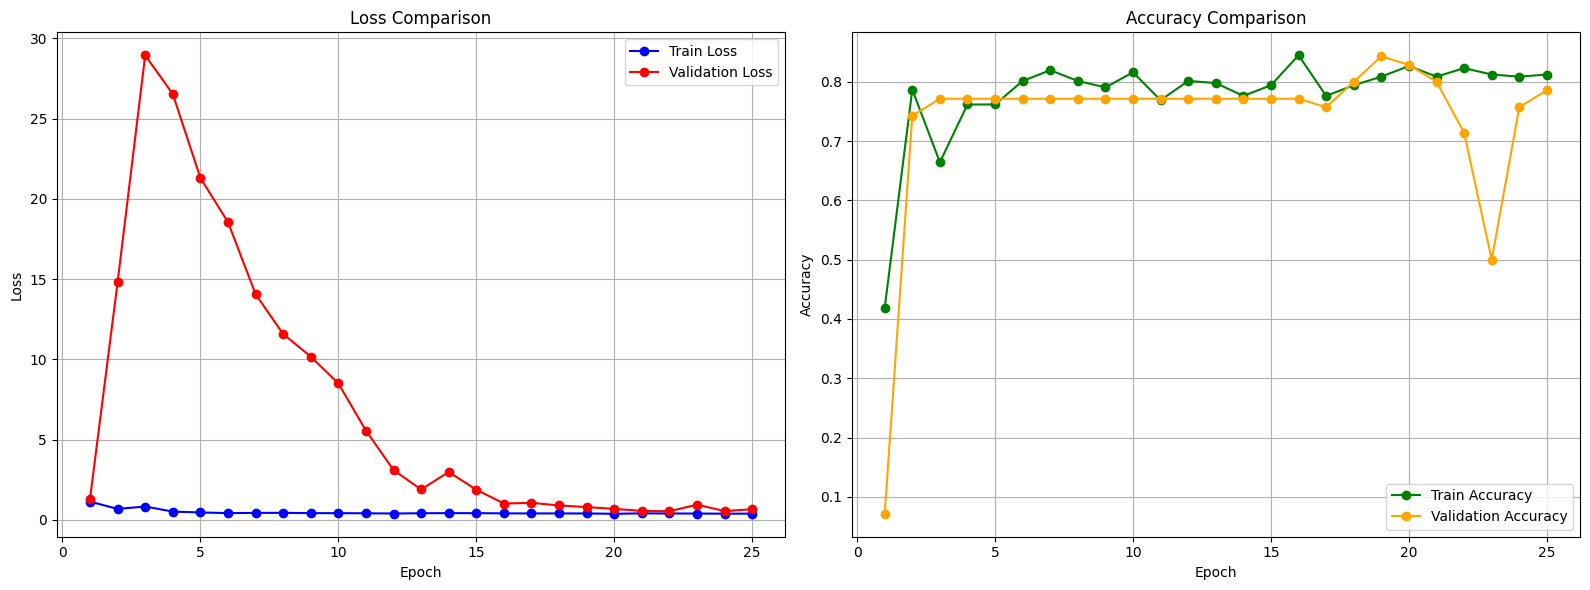

In [ ]:
import matplotlib.pyplot as plt

# 1. Función para graficar las métricas
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = list(range(1, len(train_losses) + 1))

    plt.figure(figsize=(16, 6))

    # 1. Loss (Train and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o')
    plt.title("Loss Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 2. Accuracy (Train and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.title("Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamada a la función de graficado, con las métricas ya obtenidas
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


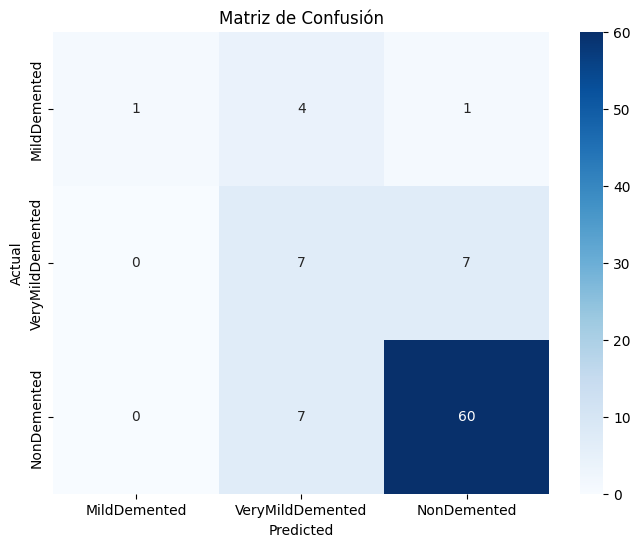

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Evaluar el modelo en el conjunto de prueba
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Crear la matriz de confusión
labels_classes = ["MildDemented", "VeryMildDemented", "NonDemented"]  # Eliminado "ModerateDemented"
cm = confusion_matrix(y_true, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels_classes, yticklabels=labels_classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Matriz de Confusión")
plt.show()


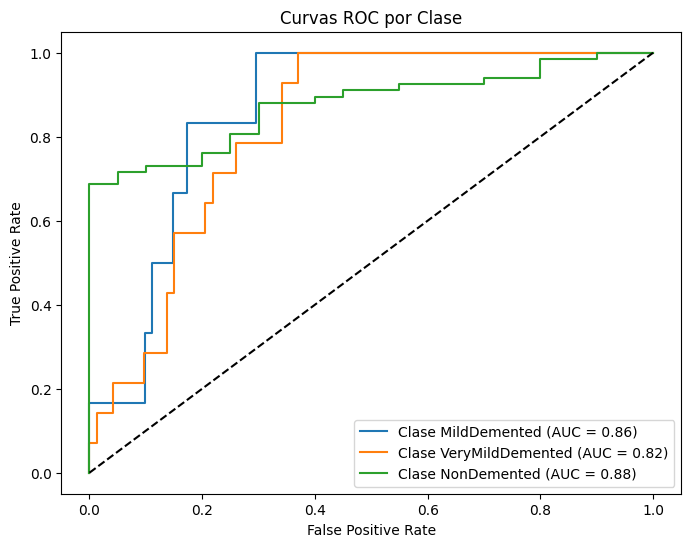

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Convertir las etiquetas en formato binario (one-vs-all) para 3 clases
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])  # Solo 3 clases ahora
y_scores = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)  # Obtiene los logits (valores antes de softmax)
        y_scores.extend(outputs.cpu().numpy())

y_scores = np.array(y_scores)

# Graficar la curva ROC para cada clase
plt.figure(figsize=(8,6))
labels_classes = ["MildDemented", "VeryMildDemented", "NonDemented"]  # Sin "ModerateDemented"

for i in range(3):  # Ahora solo 3 clases
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {labels_classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC por Clase")
plt.legend()
plt.show()
